#Image Captioning: Transformer
Simran Nayyar, Dina Dehaini, David Wang, Aditi Krishnakumar

LIGN 167

References:
https://www.tensorflow.org/tutorials/text/image_captioning
https://cs.stanford.edu/people/karpathy/cvpr2015.pdf
https://www.analyticsvidhya.com/blog/2021/01/implementation-of-attention-mechanism-for-caption-generation-on-transformers-using-tensorflow/
https://www.analyticsvidhya.com/blog/2018/04/solving-an-image-captioning-task-using-deep-learning/

Dataset: http://cocodataset.org/#home

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf

In [ ]:
import string
import numpy as np
import pandas as pd 
from numpy import array
from PIL import Image
import pickle

import matplotlib.pyplot as plt
import keras
import sys, time, os, warnings 
warnings.filterwarnings("ignore")
import re

import tensorflow as tf
from tqdm import tqdm

from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import os
import time
import json

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
   annotation_zip = tf.keras.utils.get_file('captions.zip',
                                            cache_subdir=os.path.abspath('.'),
                                            origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                            extract=True)
   annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
   os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

jpgs = os.listdir(image_folder)
print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 16182


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
annotation_file = 'annotations/captions_train2014.json'
PATH = "train2014/"
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

  # Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:10000]
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

##Caption Preprocessing

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

##Initialize InceptionV3 and load the pretrained Imagenet weights

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

##Split Data and Create tf.dataset

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv]) # number of ref captions per image
  img_name_val.extend([imgv] * capv_len) # image files * number of ref captions
  cap_val.extend(img_to_cap_vector[imgv]) # captions as vector

In [ ]:
import pickle

with open("img_name_train", "wb") as fp:   #Pickling
  pickle.dump(img_name_train, fp)
with open("img_name_val", "wb") as fp:   #Pickling
  pickle.dump(img_name_val, fp)
with open("cap_train", "wb") as fp:   #Pickling
  pickle.dump(cap_train, fp)
with open("cap_val", "wb") as fp:   #Pickling
  pickle.dump(cap_val, fp)

In [ ]:
with open("img_name_train", "rb") as fp:   # Unpickling
  img_name_train = pickle.load(fp)
with open("img_name_val", "rb") as fp:   # Unpickling
  img_name_val = pickle.load(fp)
with open("cap_train", "rb") as fp:   # Unpickling
  cap_train = pickle.load(fp)
with open("cap_val", "rb") as fp:   # Unpickling
  cap_val = pickle.load(fp)

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
valdataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
valdataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
valdataset = valdataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
valdataset = valdataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding_1d(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def positional_encoding_2d(row,col,d_model):
  assert d_model % 2 == 0
  # first d_model/2 encode row embedding and second d_model/2 encode column embedding
  row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
  col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)
  angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  #apply sin and cos to odd and even indices resp.
  angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
  angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
  angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
  angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
  pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)


In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  #adding -Inf where mask is 1 s.t. value get ignored in softmax

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask=None):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    # using look ahead mask so that during self attention current query dont consider future token
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    # use padding mask to avoid padded values of both enc_output and dec_input
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff,
               row_size,col_size,rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
    self.pos_encoding = positional_encoding_2d(row_size,col_size, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask=None):
    # shape(x) = (batch_size,seq_len(H*W),features)
    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size, 
               target_vocab_size,max_pos_encoding, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size,max_pos_encoding, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training,look_ahead_mask=None, dec_padding_mask=None,enc_padding_mask=None):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [ ]:
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = 5000 + 1
dropout_rate = 0.1

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [ ]:
transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,max_pos_encoding=target_vocab_size,rate=dropout_rate)

In [ ]:
def create_masks_decoder(tar):
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  return combined_mask

In [ ]:
@tf.function
def train_step(img_tensor, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  dec_mask = create_masks_decoder(tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(img_tensor, tar_inp, 
                                 True,  
                                 dec_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [ ]:
@tf.function
def evaluate_step(img_tensor_val, tar):
    loss = 0
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    dec_mask = create_masks_decoder(tar_inp)

    with tf.GradientTape() as tape:
      predictions, _ = transformer(img_tensor, tar_inp, 
                                 True,  
                                 dec_mask)
      loss = loss_function(tar_real, predictions)

       
    total_loss = (loss / int(target.shape[1]))
    return loss, total_loss

In [ ]:
val_losses = []
loss = []
for epoch in range(30):
  start = time.time()

  total_loss = 0
  vtotal_loss = 0
  
  train_loss.reset_states()
  train_accuracy.reset_states()

  for (batch, (img_tensor, target)) in enumerate(dataset):
    
      vbatch_loss, vt_loss = evaluate_step(img_tensor, target)
      vtotal_loss += vt_loss

      val_losses.append(vtotal_loss / num_steps)
  
  for (batch, (img_tensor, target)) in enumerate(dataset):
    train_step(img_tensor, target)
    
    if batch % 5 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      loss.append(train_loss.result())
      
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.1121 Accuracy 0.1543
Epoch 1 Batch 50 Loss 2.1148 Accuracy 0.1498
Epoch 1 Batch 100 Loss 2.1104 Accuracy 0.1505
Epoch 1 Batch 150 Loss 2.1048 Accuracy 0.1501
Epoch 1 Batch 200 Loss 2.1005 Accuracy 0.1499
Epoch 1 Batch 250 Loss 2.0993 Accuracy 0.1497
Epoch 1 Batch 300 Loss 2.0963 Accuracy 0.1500
Epoch 1 Batch 350 Loss 2.0921 Accuracy 0.1502
Epoch 1 Batch 400 Loss 2.0860 Accuracy 0.1504
Epoch 1 Batch 450 Loss 2.0807 Accuracy 0.1506
Epoch 1 Loss 2.0768 Accuracy 0.1507
Time taken for 1 epoch: 123.2374176979065 secs

Epoch 2 Batch 0 Loss 2.0040 Accuracy 0.1455
Epoch 2 Batch 50 Loss 2.0277 Accuracy 0.1524
Epoch 2 Batch 100 Loss 2.0238 Accuracy 0.1540
Epoch 2 Batch 150 Loss 2.0196 Accuracy 0.1538
Epoch 2 Batch 200 Loss 2.0152 Accuracy 0.1535
Epoch 2 Batch 250 Loss 2.0114 Accuracy 0.1538
Epoch 2 Batch 300 Loss 2.0097 Accuracy 0.1542
Epoch 2 Batch 350 Loss 2.0061 Accuracy 0.1542
Epoch 2 Batch 400 Loss 2.0012 Accuracy 0.1542
Epoch 2 Batch 450 Loss 1.9966 Accuracy 0.1544
Ep

In [ ]:
transformer.save_weights('image_caption_transformer_45.h5')

In [ ]:
def evaluate(image):

  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  
  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']
   
  #decoder input is start token.
  decoder_input = [start_token]
  output = tf.expand_dims(decoder_input, 0) #tokens
  result = [] #word list

  for i in range(100):
      dec_mask = create_masks_decoder(output)
  
      # predictions.shape == (batch_size, seq_len, vocab_size)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
      
      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      # return the result if the predicted_id is equal to the end token
      if predicted_id == end_token:
          return result,tf.squeeze(output, axis=0), attention_weights
      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

  return result,tf.squeeze(output, axis=0), attention_weights

BLEU-1 score: 37.5
BLEU-2 score: 61.237243569579455
BLEU-3 score: 74.5091107671223
BLEU-4 score: 78.25422900366436
Real Caption: young girl is playing in fountain of water
Predicted Caption: young boy plays in the water without shirt


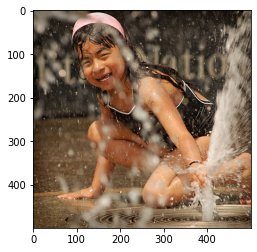

In [ ]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


BLEU-1 score: 33.33333333333333
BLEU-2 score: 57.735026918962575
BLEU-3 score: 71.92230933248644
BLEU-4 score: 75.98356856515926
Real Caption: dog standing outside is looking at the camera
Predicted Caption: tan and white dog is running through the leaves


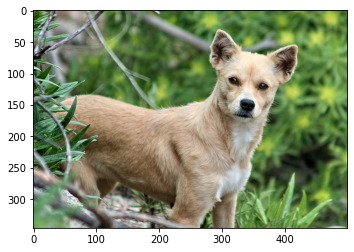

In [ ]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


In [ ]:
# OLD BLEU WITH 1 REF
i = 0
bleu_1 = [] # weights = 1,0,0,0
bleu_4 = [] # weights = 0.25, 0.25, 0.25, 0.25

# iterate through validation set
while i < len(img_name_val):
  start_token = tokenizer.word_index['<start>']
  cap_len = len(img_to_cap_vector[img_name_val[i]])
  end_token = tokenizer.word_index['<end>']
  # select random image from validation data
  rid = i
  image = img_name_val[i]
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
  caption,result,attention_weights = evaluate(image)

  first = real_caption.split(' ', 1)[1]
  real_caption = first.rsplit(' ', 1)[0]

  #remove "<unk>" in result
  for i in caption:
      if i=="<unk>":
          caption.remove(i)

  for i in real_caption:
      if i=="<unk>":
          real_caption.remove(i)

  #remove <end> from result         
  result_join = ' '.join(caption)
  result_final = result_join.rsplit(' ', 1)[0]

  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = caption
  score1 = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
  score2 = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
  score3 = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
  score4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))

  bleu_1.append(score1)
  bleu_4.append(score4)

  i += cap_len

Text(0.5, 1.0, 'Bleu Score per Image')

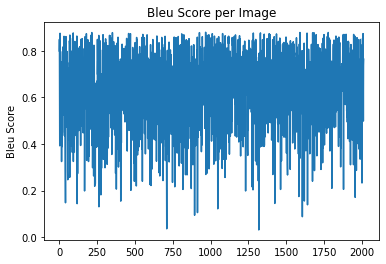

In [ ]:
import matplotlib.pyplot as plt
plt.plot(bleu_4)
plt.ylabel('Bleu Score')
plt.title('Bleu Score per Image')